In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import requests
from pathlib import Path
from tqdm.auto import tqdm
import torchvision.transforms as transforms
import os
import random
from PIL import Image
from timeit import default_timer as timer
import zipfile
from typing import Tuple, Dict, List
from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, f1_score
import seaborn as sns

C:\Users\janex\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [3]:
data_path = Path("data/")
image_path = data_path / "spectrogramy"
zip_file_path = data_path / "spektogramy2080.zip"

if image_path.is_dir():
    print(f"{image_path} directory already exists")
else:
    print(f"{image_path} does not exist, creating one")
    image_path.mkdir(parents=True, exist_ok=True)

if zip_file_path.is_file():
  with zipfile.ZipFile(zip_file_path, "r") as zip_ref:
    print("Unzipping spectrogramy...")
    zip_ref.extractall(image_path)

data\spectrogramy directory already exists
Unzipping spectrogramy...


In [5]:
#!rm -r data

In [4]:
def walk_through_dir(dir_path):
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} diectories and {len(filenames)} images in '{dirpath}' .")

In [6]:
walk_through_dir(image_path)

There are 2 diectories and 0 images in 'data\spectrogramy' .
There are 6 diectories and 0 images in 'data\spectrogramy\test' .
There are 0 diectories and 16 images in 'data\spectrogramy\test\A' .
There are 0 diectories and 16 images in 'data\spectrogramy\test\B' .
There are 0 diectories and 16 images in 'data\spectrogramy\test\C' .
There are 0 diectories and 16 images in 'data\spectrogramy\test\D' .
There are 0 diectories and 16 images in 'data\spectrogramy\test\E' .
There are 0 diectories and 16 images in 'data\spectrogramy\test\F' .
There are 6 diectories and 0 images in 'data\spectrogramy\train' .
There are 0 diectories and 64 images in 'data\spectrogramy\train\A' .
There are 0 diectories and 64 images in 'data\spectrogramy\train\B' .
There are 0 diectories and 64 images in 'data\spectrogramy\train\C' .
There are 0 diectories and 64 images in 'data\spectrogramy\train\D' .
There are 0 diectories and 64 images in 'data\spectrogramy\train\E' .
There are 0 diectories and 64 images in 'd

In [7]:
train_dir = image_path / "train"
test_dir = image_path / "test"
print(f"'{train_dir}' \n'{test_dir}'")

'data\spectrogramy\train' 
'data\spectrogramy\test'


In [8]:
def convert_to_rgb(img):
    return img.convert("RGB")

simple_transform = transforms.Compose([
    transforms.CenterCrop(size=(310, 700)),
    transforms.Lambda(convert_to_rgb),
    transforms.Resize(size=(64, 64)),
    transforms.ToTensor()
])

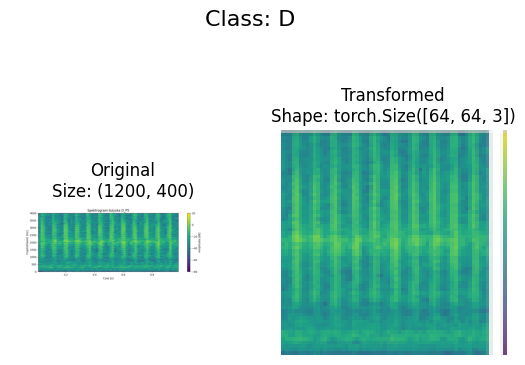

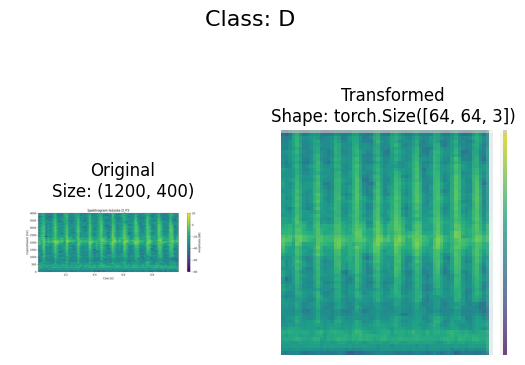

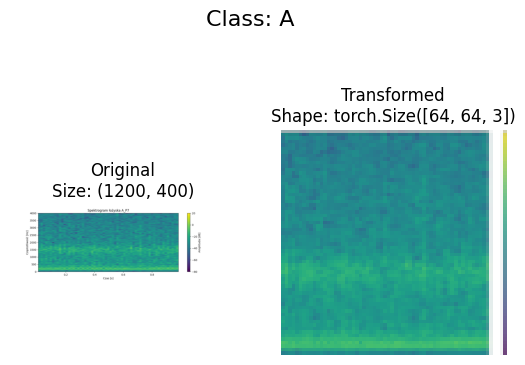

In [9]:
image_path_list = list(image_path.glob("*/*/*.png"))

def plot_transformed_images(image_paths: list, transform, n=3, seed=None):
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      transformed_image = transform(f).permute(1, 2, 0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_paths=image_path_list,
                        transform=simple_transform,
                        n=3,
                        seed=42)

In [10]:
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

BATCH_SIZE = 32
#NUM_WORKERS = os.cpu_count()
NUM_WORKERS = 0

train_dataloader_simple = DataLoader(dataset=train_data_simple,
                                     batch_size=BATCH_SIZE,
                                     num_workers=NUM_WORKERS,
                                     shuffle=True)
test_dataloader_simple = DataLoader(dataset=test_data_simple,
                                    batch_size=BATCH_SIZE,
                                    num_workers=NUM_WORKERS,
                                    shuffle=False)

In [11]:
class CustomTinyVGG(nn.Module):
  def __init__(self,
               input_shape: int,
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels=input_shape,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)                                              # default stride value is same as kernel size
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.Conv2d(in_channels=hidden_units,
                  out_channels=hidden_units,
                  kernel_size=3,
                  stride=1,
                  padding=0),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2,
                     stride=2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*13*13,                            # Sztuczka do ustalania przez ile mnozyc
                  out_features=output_shape)
    )
  def forward(self, x):
    x = self.conv_block_1(x)
    #print(x.shape)
    x = self.conv_block_2(x)
    #print(x.shape)
    x = self.classifier(x)
    #print(x.shape)
    return x
      #return self.classifier(self.conv_block_2(self.conv_block_1(x))) # benefits from operation fusion

In [12]:
torch.manual_seed(42)
model_0 = CustomTinyVGG(input_shape=3, #number of collor chanels in image data
                  hidden_units=20,
                  output_shape=len(train_data_simple.classes)).to(device)

model_0

CustomTinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(20, 20, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=3380, out_features=6, bias=True)
  )
)

In [13]:
image_batch, label_batch = next(iter(train_dataloader_simple))
image_batch.shape, label_batch.shape

(torch.Size([32, 3, 64, 64]), torch.Size([32]))

In [14]:
model_0(image_batch.to(device))

tensor([[-0.0363,  0.0098, -0.0300,  0.0384, -0.0051, -0.0182],
        [-0.0356,  0.0092, -0.0282,  0.0385, -0.0049, -0.0186],
        [-0.0347,  0.0098, -0.0259,  0.0400, -0.0053, -0.0188],
        [-0.0361,  0.0087, -0.0304,  0.0385, -0.0042, -0.0193],
        [-0.0364,  0.0096, -0.0278,  0.0392, -0.0046, -0.0188],
        [-0.0339,  0.0090, -0.0265,  0.0396, -0.0066, -0.0194],
        [-0.0362,  0.0078, -0.0310,  0.0394, -0.0043, -0.0180],
        [-0.0358,  0.0084, -0.0311,  0.0396, -0.0046, -0.0178],
        [-0.0359,  0.0079, -0.0308,  0.0394, -0.0043, -0.0181],
        [-0.0356,  0.0091, -0.0292,  0.0406, -0.0039, -0.0171],
        [-0.0356,  0.0085, -0.0282,  0.0387, -0.0047, -0.0186],
        [-0.0348,  0.0094, -0.0270,  0.0413, -0.0057, -0.0174],
        [-0.0368,  0.0091, -0.0303,  0.0396, -0.0048, -0.0186],
        [-0.0360,  0.0097, -0.0304,  0.0388, -0.0039, -0.0187],
        [-0.0356,  0.0085, -0.0287,  0.0403, -0.0043, -0.0172],
        [-0.0367,  0.0093, -0.0283,  0.0

In [15]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo

from torchinfo import summary

summary(model_0, input_size=[1, 3, 64, 64])

Layer (type:depth-idx)                   Output Shape              Param #
CustomTinyVGG                            [1, 6]                    --
├─Sequential: 1-1                        [1, 20, 30, 30]           --
│    └─Conv2d: 2-1                       [1, 20, 62, 62]           560
│    └─ReLU: 2-2                         [1, 20, 62, 62]           --
│    └─Conv2d: 2-3                       [1, 20, 60, 60]           3,620
│    └─ReLU: 2-4                         [1, 20, 60, 60]           --
│    └─MaxPool2d: 2-5                    [1, 20, 30, 30]           --
├─Sequential: 1-2                        [1, 20, 13, 13]           --
│    └─Conv2d: 2-6                       [1, 20, 28, 28]           3,620
│    └─ReLU: 2-7                         [1, 20, 28, 28]           --
│    └─Conv2d: 2-8                       [1, 20, 26, 26]           3,620
│    └─ReLU: 2-9                         [1, 20, 26, 26]           --
│    └─MaxPool2d: 2-10                   [1, 20, 13, 13]           --
├─Seq

In [16]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device=device):
  model.train()

  train_loss, train_acc = 0, 0

  for batch, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)

    y_pred = model(X)

    loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
    train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)

  return train_loss, train_acc

In [17]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device=device):
  model.eval()

  test_loss, test_acc = 0, 0
  all_preds = []
  all_labels = []


  with torch.inference_mode():
    for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      test_pred_logits = model(X)

      loss = loss_fn(test_pred_logits, y)
      test_loss += loss.item()

      test_pred_labels = test_pred_logits.argmax(dim=1)
      test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

      all_preds.append(test_pred_labels)
      all_labels.append(y)

  all_preds = torch.cat(all_preds)
  all_labels = torch.cat(all_labels)

  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc, all_preds, all_labels

In [18]:
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss,
          epochs: int=5,
          device=device):
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []}

  final_preds = []
  final_labels = []
  labels = ['A', 'B', 'C', 'D', 'E', 'F']

  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn=loss_fn,
                                       optimizer=optimizer,
                                       device=device)
    test_loss, test_acc, epoch_preds, epoch_labels = test_step(model=model,
                                                               dataloader=test_dataloader,
                                                               loss_fn=loss_fn,
                                                               device=device)

    if epoch == epochs - 1:
      final_preds = epoch_preds
      final_labels = epoch_labels

    print(f"Epoch: {epoch} | Train loss: {train_loss:.4f} | Train acc: {train_acc:.4f} | Test loss: {test_loss:.4f} | Test acc: {test_acc:.4f}")

    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  final_preds = final_preds.cpu()
  final_labels = final_labels.cpu()

  conf_matrix = confusion_matrix(final_labels, final_preds)

  plt.figure(figsize=(8, 6))
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
  plt.xlabel("Przewidywane")
  plt.ylabel("Rzeczywiste")
  plt.title("Macierz pomyłek")
  plt.show()

  report = classification_report(final_labels, final_preds, target_names=labels)
  print("Raport klasyfikacji:")
  print(report)

  return results

  3%|▎         | 1/30 [00:08<04:15,  8.82s/it]

Epoch: 0 | Train loss: 1.7923 | Train acc: 0.1615 | Test loss: 1.7773 | Test acc: 0.1667


  7%|▋         | 2/30 [00:14<03:13,  6.89s/it]

Epoch: 1 | Train loss: 1.7560 | Train acc: 0.2057 | Test loss: 1.6963 | Test acc: 0.3333


 10%|█         | 3/30 [00:19<02:45,  6.12s/it]

Epoch: 2 | Train loss: 1.5975 | Train acc: 0.3828 | Test loss: 1.4250 | Test acc: 0.5000


 13%|█▎        | 4/30 [00:24<02:29,  5.73s/it]

Epoch: 3 | Train loss: 1.2343 | Train acc: 0.5781 | Test loss: 0.9499 | Test acc: 0.7292


 17%|█▋        | 5/30 [00:29<02:17,  5.49s/it]

Epoch: 4 | Train loss: 0.7447 | Train acc: 0.7474 | Test loss: 0.5902 | Test acc: 0.7917


 20%|██        | 6/30 [00:34<02:07,  5.33s/it]

Epoch: 5 | Train loss: 0.4731 | Train acc: 0.8073 | Test loss: 0.3983 | Test acc: 0.8438


 23%|██▎       | 7/30 [00:39<02:00,  5.23s/it]

Epoch: 6 | Train loss: 0.3188 | Train acc: 0.8750 | Test loss: 0.1915 | Test acc: 1.0000


 27%|██▋       | 8/30 [00:44<01:53,  5.18s/it]

Epoch: 7 | Train loss: 0.1693 | Train acc: 0.9974 | Test loss: 0.1316 | Test acc: 1.0000


 30%|███       | 9/30 [00:49<01:47,  5.13s/it]

Epoch: 8 | Train loss: 0.1030 | Train acc: 0.9974 | Test loss: 0.0788 | Test acc: 1.0000


 33%|███▎      | 10/30 [00:54<01:42,  5.11s/it]

Epoch: 9 | Train loss: 0.0628 | Train acc: 1.0000 | Test loss: 0.0517 | Test acc: 1.0000


 37%|███▋      | 11/30 [01:00<01:37,  5.11s/it]

Epoch: 10 | Train loss: 0.0440 | Train acc: 0.9974 | Test loss: 0.0451 | Test acc: 1.0000


 40%|████      | 12/30 [01:05<01:31,  5.09s/it]

Epoch: 11 | Train loss: 0.0346 | Train acc: 1.0000 | Test loss: 0.0364 | Test acc: 1.0000


 43%|████▎     | 13/30 [01:10<01:26,  5.08s/it]

Epoch: 12 | Train loss: 0.0312 | Train acc: 1.0000 | Test loss: 0.0210 | Test acc: 1.0000


 47%|████▋     | 14/30 [01:15<01:21,  5.07s/it]

Epoch: 13 | Train loss: 0.0288 | Train acc: 0.9948 | Test loss: 0.0248 | Test acc: 1.0000


 50%|█████     | 15/30 [01:20<01:16,  5.08s/it]

Epoch: 14 | Train loss: 0.0220 | Train acc: 1.0000 | Test loss: 0.0200 | Test acc: 1.0000


 53%|█████▎    | 16/30 [01:25<01:10,  5.06s/it]

Epoch: 15 | Train loss: 0.0129 | Train acc: 1.0000 | Test loss: 0.0111 | Test acc: 1.0000


 57%|█████▋    | 17/30 [01:30<01:05,  5.04s/it]

Epoch: 16 | Train loss: 0.0111 | Train acc: 1.0000 | Test loss: 0.0095 | Test acc: 1.0000


 60%|██████    | 18/30 [01:35<01:00,  5.07s/it]

Epoch: 17 | Train loss: 0.0085 | Train acc: 1.0000 | Test loss: 0.0110 | Test acc: 1.0000


 63%|██████▎   | 19/30 [01:40<00:55,  5.09s/it]

Epoch: 18 | Train loss: 0.0077 | Train acc: 1.0000 | Test loss: 0.0072 | Test acc: 1.0000


 67%|██████▋   | 20/30 [01:45<00:50,  5.09s/it]

Epoch: 19 | Train loss: 0.0060 | Train acc: 1.0000 | Test loss: 0.0062 | Test acc: 1.0000


 70%|███████   | 21/30 [01:50<00:45,  5.09s/it]

Epoch: 20 | Train loss: 0.0073 | Train acc: 1.0000 | Test loss: 0.0112 | Test acc: 1.0000


 73%|███████▎  | 22/30 [01:55<00:40,  5.08s/it]

Epoch: 21 | Train loss: 0.0063 | Train acc: 1.0000 | Test loss: 0.0059 | Test acc: 1.0000


 77%|███████▋  | 23/30 [02:00<00:35,  5.06s/it]

Epoch: 22 | Train loss: 0.0048 | Train acc: 1.0000 | Test loss: 0.0048 | Test acc: 1.0000


 80%|████████  | 24/30 [02:05<00:30,  5.05s/it]

Epoch: 23 | Train loss: 0.0035 | Train acc: 1.0000 | Test loss: 0.0039 | Test acc: 1.0000


 83%|████████▎ | 25/30 [02:10<00:25,  5.06s/it]

Epoch: 24 | Train loss: 0.0032 | Train acc: 1.0000 | Test loss: 0.0038 | Test acc: 1.0000


 87%|████████▋ | 26/30 [02:15<00:20,  5.05s/it]

Epoch: 25 | Train loss: 0.0033 | Train acc: 1.0000 | Test loss: 0.0039 | Test acc: 1.0000


 90%|█████████ | 27/30 [02:21<00:15,  5.04s/it]

Epoch: 26 | Train loss: 0.0031 | Train acc: 1.0000 | Test loss: 0.0033 | Test acc: 1.0000


 93%|█████████▎| 28/30 [02:26<00:10,  5.03s/it]

Epoch: 27 | Train loss: 0.0031 | Train acc: 1.0000 | Test loss: 0.0042 | Test acc: 1.0000


 97%|█████████▋| 29/30 [02:31<00:05,  5.06s/it]

Epoch: 28 | Train loss: 0.0024 | Train acc: 1.0000 | Test loss: 0.0030 | Test acc: 1.0000


100%|██████████| 30/30 [02:36<00:00,  5.21s/it]

Epoch: 29 | Train loss: 0.0023 | Train acc: 1.0000 | Test loss: 0.0027 | Test acc: 1.0000


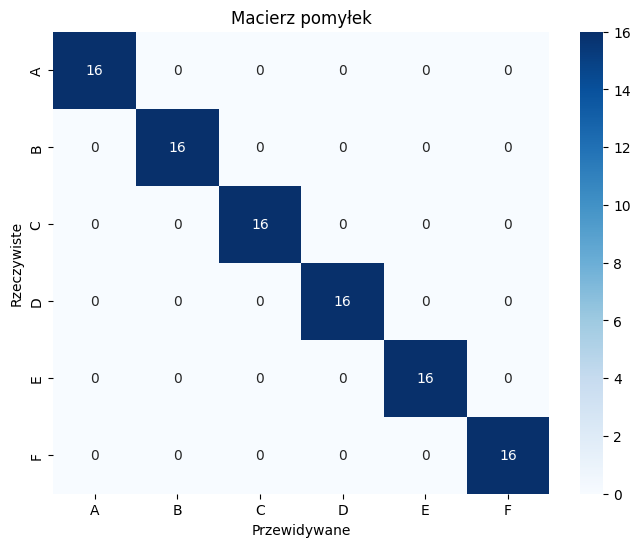

Raport klasyfikacji:
              precision    recall  f1-score   support

           A       1.00      1.00      1.00        16
           B       1.00      1.00      1.00        16
           C       1.00      1.00      1.00        16
           D       1.00      1.00      1.00        16
           E       1.00      1.00      1.00        16
           F       1.00      1.00      1.00        16

    accuracy                           1.00        96
   macro avg       1.00      1.00      1.00        96
weighted avg       1.00      1.00      1.00        96

Total training time: 156.541 seconds.


In [19]:
#torch.manual_seef(42)
#torch.cuda.manual_seed(42)

NUM_EPOCHS = 30
model_0 = CustomTinyVGG(input_shape=3,
                  hidden_units=10,
                  output_shape=len(train_data_simple.classes)).to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(),
                             lr=0.001)

start_time = timer()

model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds.")

In [24]:
def plot_loss_curves(results: Dict[str, List[float]]):
  "plots trainnig curves of a results dictionary"

  loss = results["train_loss"]
  test_loss = results["test_loss"]
  accuracy = results["train_acc"]
  test_accuracy = results["test_acc"]

  epochs = range(len(results["train_loss"]))

  plt.figure(figsize=(15, 7))
  plt.subplot(1, 2, 1)
  plt.plot(epochs, loss, label="train_loss")
  plt.plot(epochs, test_loss, label="test_loss")
  plt.title("Loss")
  plt.xlabel("Epochs")
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.plot(epochs, accuracy, label="train_accuracy")
  plt.plot(epochs, test_accuracy, label="test_accuracy")
  plt.title("Accuracy")
  plt.xlabel("Epochs")
  plt.legend()

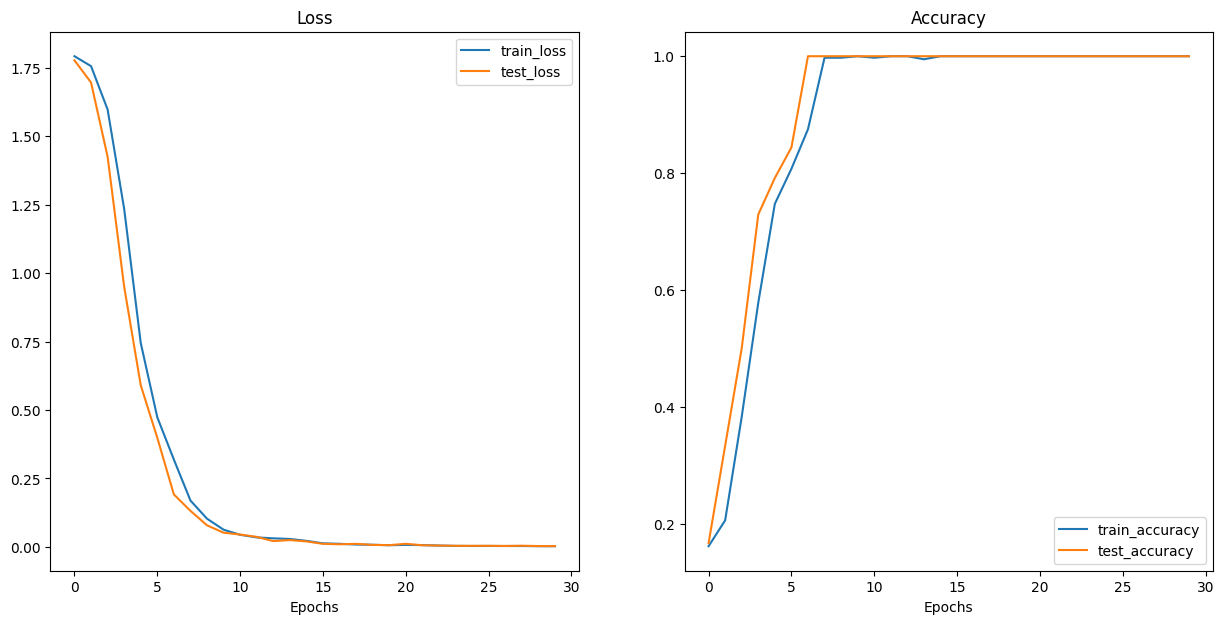

In [25]:
plot_loss_curves(model_0_results)

In [26]:
MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "CNN_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
torch.save(obj=model_0.state_dict(),
           f=MODEL_SAVE_PATH)

In [27]:
len(test_data_simple)

96